<h1 align="center">Insurance Claims ETL & Analytics Project</h1>

### Data ingestion in HDFS
```bash
hdfs dfs -mkdir insurancedata
hdfs dfs -put insurance_claims.csv insurancedata/
```
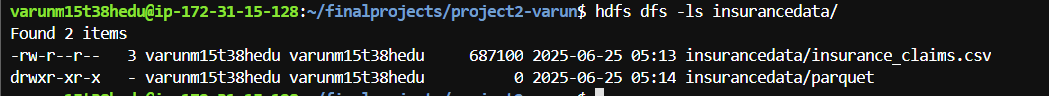

### Importing python packages

```python
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation
```

```python
spark = SparkSession.builder.appName("VarunInsClaim").master("local[5]").enableHiveSupport().getOrCreate()
```
```python
sc = spark.sparkContext
sc.setLogLevel("ERROR")
```

### Load Data
```python
insurance = spark.read.csv("insurancedata/insurance_claims.csv",sep=',',header=True, inferSchema=True)
```

### Handling Null values
```python
null_counts = insurance.select([sum(col(c).isNull().cast('int')).alias(c) for c in insurance.columns])
null_counts.show()
```

```python
insurance.count()
```

### Dropping Null values

```python
insurance = insurance.na.drop()
```
```python
insurance.count()
```

### Typecasting incident_date to dateType
```python
insurance = insurance.withColumn("incident_date", to_date(insurance.incident_date))
```

### Extract year from incident_date
```python
insurance = insurance.withColumn("incident_year",year(insurance.incident_date))
```

### Hive table creation

```sql
use varunmdb;

create external table IF NOT EXISTS insurance_claim(
months_as_customer int  ,age int
,policy_number string 
,policy_state string , policy_csl string 
,policy_deductable int
,policy_annual_premium double 
,umbrella_limit int 
,insured_zip int 
,insured_sex string 
,insured_education_level string
,insured_occupation string 
,insured_hobbies string 
,insured_relationship string
,capital_gains double 
,capital_loss double 
,incident_date date
,incident_type string 
,collision_type string 
,incident_severity string 
,authorities_contacted string 
,incident_state string 
,incident_city string 
,incident_location string 
,incident_hour_of_the_day int 
,number_of_vehicles_involved int 
,property_damage string 
,bodily_injuries int 
,witnesses int  
,police_report_available string  
,total_claim_amount double 
,injury_claim double 
,property_claim double 
,vehicle_claim double 
,auto_make string
,auto_model string 
,auto_year int
,fraud_reported string )                                                                
PARTITIONED BY (incident_year int) 
STORED AS parquet 
location '/user/varunm15t38hedu/insurance/parquet/';
```

### write data into hdfs , partitioning by `incident_year`
```python
insurance.write.mode("overwrite").partitionBy("incident_year").parquet("insurancedata/parquet")
```
### repairing partitions
```python
spark.sql("msck repair table varunmdb.insurance_claim")
```
```python
spark.sql("select * from varunmdb.insurance_claim limit 10").show()
```

### 1. Fraud rate per year.
```python
insurance.select(["incident_year", "fraud_reported"]).filter(insurance.fraud_reported=="Y").groupBy(col("incident_year")).count().alias("count").orderBy(col("count").desc()).show()
```
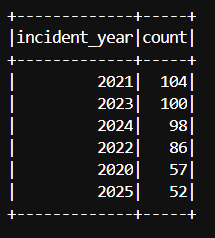

### 2. Average claim amount by incident severity and fraud flag.
```python
insurance.select(["incident_severity","fraud_reported","total_claim_amount"]).groupBy(col("incident_severity"),col("fraud_reported")).avg("total_claim_amount").show()
```
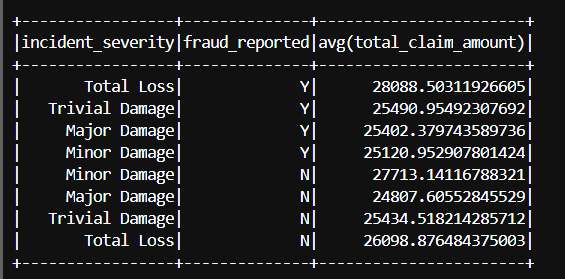

### 3. Top 5 vehicle makes with the highest total claim amount.
```python
insurance.select(["auto_make", "total_claim_amount"]).orderBy(col("total_claim_amount").desc()).show(5)
```
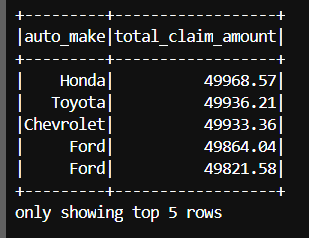

### 4. Correlation between customer tenure and fraud likelihood.
```python
fr_cust = insurance.select(['months_as_customer','fraud_reported'])

fr_cust = fr_cust.withColumn("fraud_reported", when(col("fraud_reported")=="Y",1).when(col("fraud_reported")=="N",0))

correlation=fr_cust.stat.corr('months_as_customer','fraud_reported')
print(correlation)
```
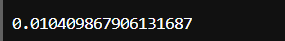

5. Claim type breakdown (injury, property, vehicle) by fraud flag.
```python
insurance.agg(count('injury_claim')).show()


insurance=insurance.withColumn('injury',when(col('injury_claim')>0,1).otherwise(0)).withColumn('property',when(col('property_claim')>0,1).otherwise(0)).withColumn('vehicle',when(col('vehicle_claim')>0,1).otherwise(0))
claim_type=insurance.groupBy('fraud_reported').agg(sum('injury').alias('injury'),sum('property').alias('property'),sum('vehicle').alias('vehicle'))
claim_type.show()
```
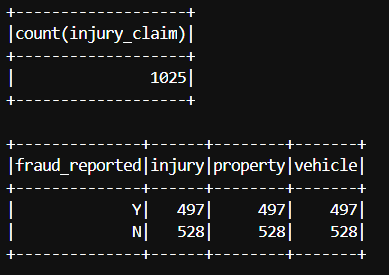
```python
spark.stop()
```

<h1 align="center">Thank You</h1>